In [1]:
# -*- encoding: utf-8 -*-
import sys
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# env: windows
PATH_IMAGE = 'D:\\My_Data\\me_Docs\\Masterarbeit\\master_border_extraction\\images\\test1.png'
img_bgr_origin = cv2.imread(PATH_IMAGE, cv2.IMREAD_COLOR)  # color image
img_gray_origin = cv2.imread(PATH_IMAGE, cv2.IMREAD_GRAYSCALE) # gray image
img_rgb = cv2.cvtColor(img_bgr_origin, cv2.COLOR_BGR2RGB)

In [2]:
### Basic Infos
dimensions = img_gray_origin.shape
print(dimensions) # (2064, 3088, 3) => height, width pixels, channels 

(2064, 3088)


(<AxesSubplot:title={'center':'grayscale'}>,
 Text(0.5, 1.0, 'grayscale'),
 <matplotlib.image.AxesImage at 0x1ae37d98850>)

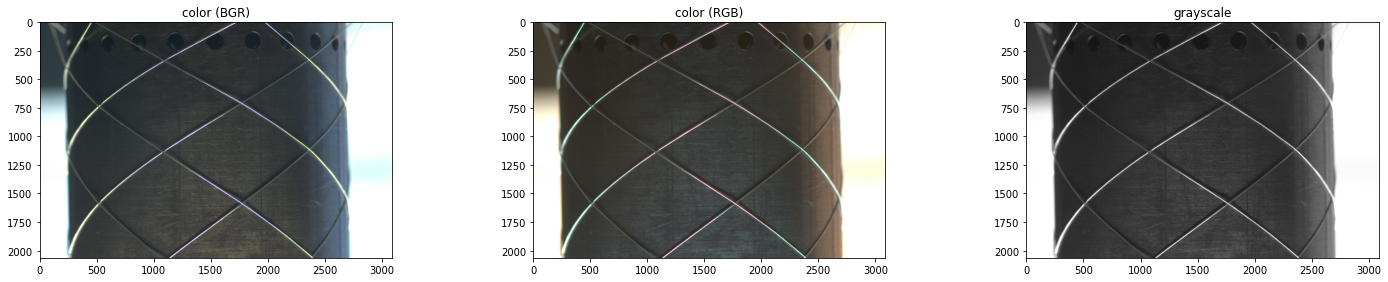

In [3]:
### Info: color & grayscale images
plt.subplots(1, 3, figsize=(24, 13.5))
plt.subplots_adjust(wspace=0.4, hspace=0.4) # adjust the distance between subplots

plt.subplot(131), plt.title('color (BGR)'), plt.imshow(img_bgr_origin)  
plt.subplot(132), plt.title('color (RGB)'), plt.imshow(img_rgb)  
plt.subplot(133), plt.title('grayscale'), plt.imshow(img_gray_origin, cmap='gray')  

## Step1. Smoothing

bilateralFilter()
- kernel size: d=5
- sigma of color: sigmaColor=20
- sigma of space: sigmaSpace=20

In [4]:
img_gray_bilat = cv2.bilateralFilter(img_gray_origin, d=5, sigmaColor=20, sigmaSpace=20)

jointBilateralFilter()
- & Gaussian filter: 
    - ksize
    - sigmaX
- d
- sigmaColor
- sigmaSpace

In [5]:
# gauss filter is used as guided image(joint)
img_gauss = cv2.GaussianBlur(img_gray_origin, ksize=(5, 5), sigmaX=1)
img_gray_jointBilat = cv2.ximgproc.jointBilateralFilter(img_gauss, img_gray_origin, d=5, sigmaColor=10, sigmaSpace=5)


GuidedFilter.filter()
- radius
- eps

In [6]:
img_gray_guided = cv2.ximgproc.guidedFilter(guide=img_rgb, 
                                            src=img_gray_origin,
                                            radius=10,
                                            eps=2)

## Step2. Histogramm Enhancement

Check: Histogramm

(Text(0.5, 1.0, 'Grayscale histogramm distribution'),
 [<matplotlib.lines.Line2D at 0x1ae38079a60>])

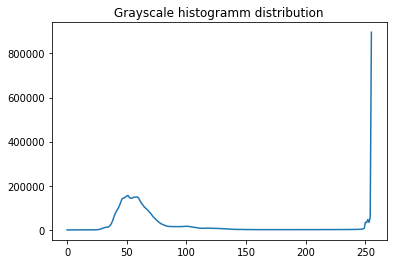

In [7]:
hist_gray = cv2.calcHist([img_gray_origin],[0],None,[256],[0,256])   # shape is (256, 1)
plt.title('Grayscale histogramm distribution'), plt.plot(hist_gray)

!!! TODOs
- [1] discover the meaning of two parts
- [2] set the left part to 0 => check the effect

1 Equalization (HE)

(<AxesSubplot:title={'center':'Grayscale with HE'}>,
 Text(0.5, 1.0, 'Grayscale with HE'),
 [<matplotlib.lines.Line2D at 0x1ae38124a90>])

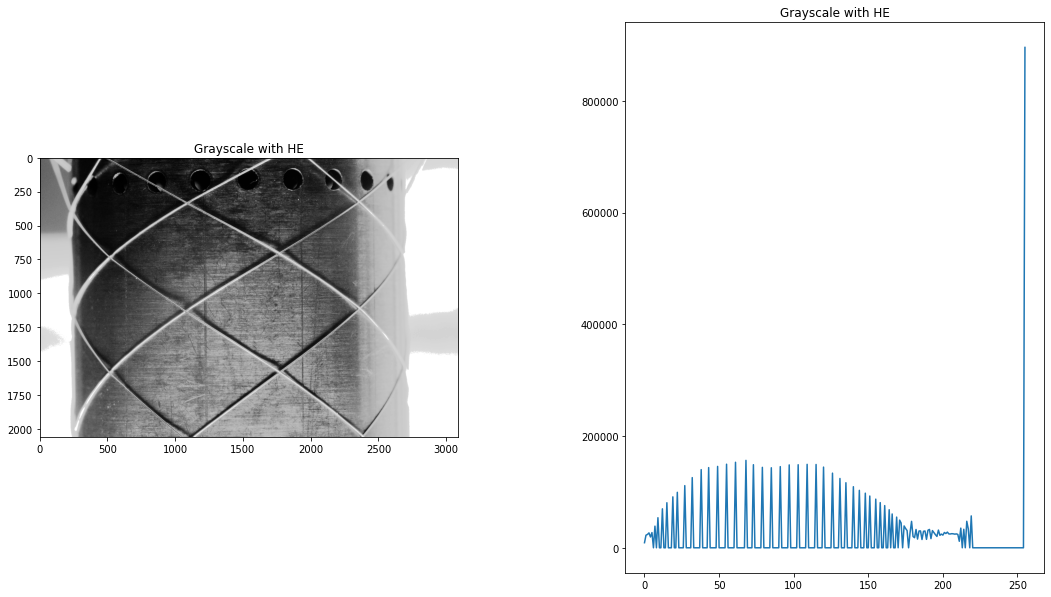

In [8]:
gray_equal = cv2.equalizeHist(img_gray_origin)
hist_gray_equal = cv2.calcHist([gray_equal],[0],None,[256],[0,256])   # shape is (256, 1)

plt.figure(figsize=(18, 10.125))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(121), plt.title('Grayscale with HE'), plt.imshow(gray_equal, cmap='gray')
plt.subplot(122), plt.title('Grayscale with HE'), plt.plot(hist_gray_equal)

2 Contrast Limited AHE (CLAHE)
- clipLimit
- tileGridSize

(<AxesSubplot:title={'center':'Grayscale with CLAHE'}>,
 Text(0.5, 1.0, 'Grayscale with CLAHE'),
 [<matplotlib.lines.Line2D at 0x1ae38876400>])

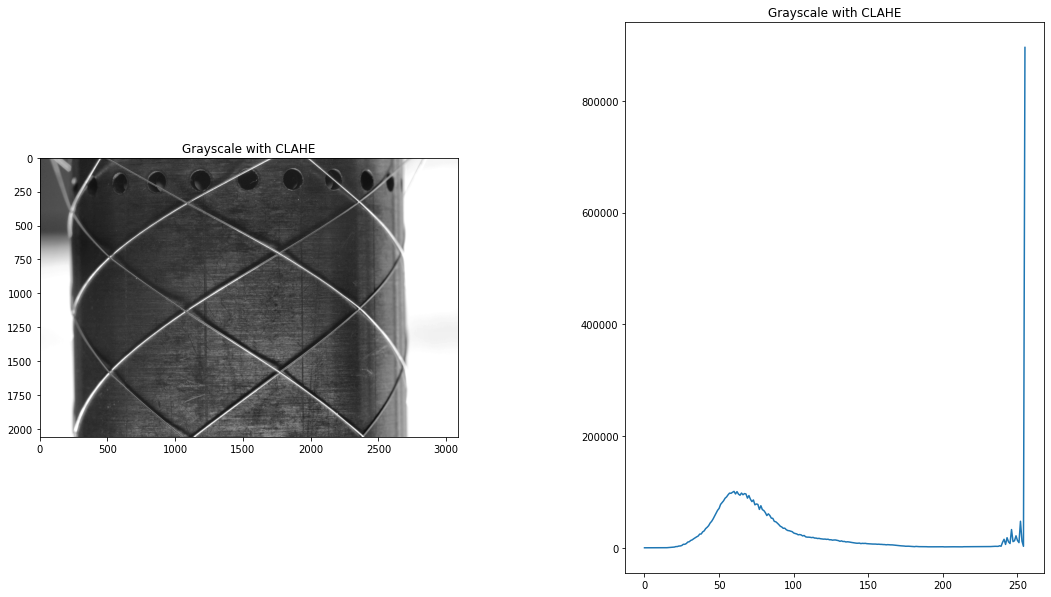

In [9]:
# grayscale
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_clahe = clahe.apply(img_gray_origin)

hist_gray_clahe = cv2.calcHist([gray_clahe],[0],None,[256],[0,256])   # shape is (256, 1)

plt.figure(figsize=(18, 10.125))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(121), plt.title('Grayscale with CLAHE'), plt.imshow(gray_clahe, cmap='gray')
plt.subplot(122), plt.title('Grayscale with CLAHE'), plt.plot(hist_gray_clahe)

## Step3. Sharpening

In [10]:
# import libraries of designed filters 
from _homomorphicFilter import homomorphic_filter as homo_filter
from _marrHildrethFilter import edgesMarrHildreth as marrFilter

Spatial domain: USM

(<Figure size 1728x972 with 1 Axes>,
 Text(0.5, 1.0, 'Sharpening: USM (right)'),
 <matplotlib.image.AxesImage at 0x1ae4b530580>)

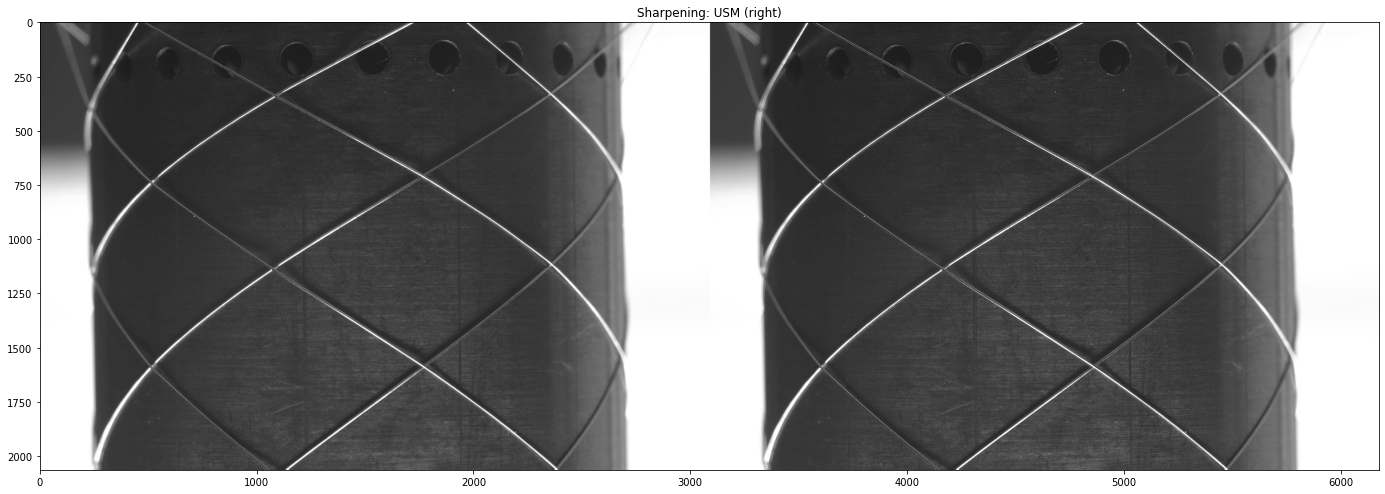

In [11]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
gray_USM = cv2.filter2D(src=img_gray_origin, ddepth=-1, kernel=kernel)
sharp_USM = np.hstack((img_gray_origin, gray_USM))
plt.figure(figsize=(24, 13.5)), plt.title('Sharpening: USM (right)'), plt.imshow(sharp_USM, cmap='gray')  


Frequency domain: Hormorphic filter

(<Figure size 1728x972 with 1 Axes>,
 Text(0.5, 1.0, 'Sharpening: Homomorphic Filter (right)'),
 <matplotlib.image.AxesImage at 0x1ae4dacc880>)

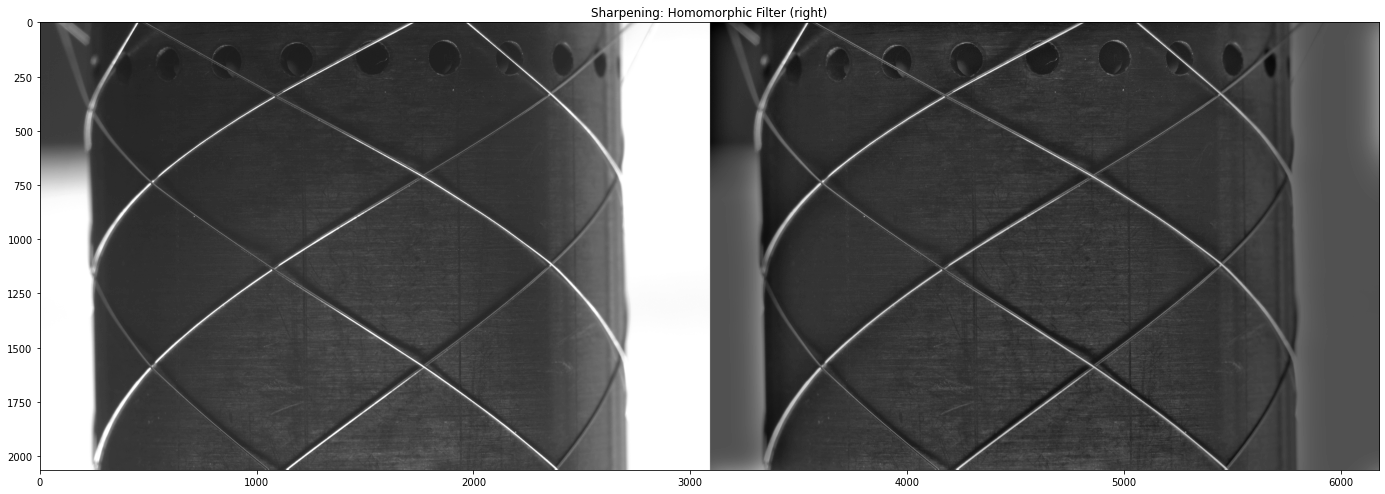

In [12]:
# img = cv2.resize(img, (400, 400))
img_homo_filtered = homo_filter(img_gray_origin)

sharp_homor = np.hstack((img_gray_origin, img_homo_filtered))
plt.figure(figsize=(24, 13.5)), plt.title('Sharpening: Homomorphic Filter (right)'), plt.imshow(sharp_homor, cmap='gray')  

## TEST for edge detection descriptor

TEST: canny filter

In [13]:
edges = cv2.Canny(img_gray_origin, 70, 80)  # the upper threshold should be lower (about 80)
sharpening_contrast = np.hstack((img_gray_origin, edges))
cv2.namedWindow("canny filter", cv2.WINDOW_NORMAL) 
cv2.imshow('canny filter', sharpening_contrast)
cv2.waitKey()
cv2.destroyAllWindows()

TEST: Marr-Hildreth

(<AxesSubplot:title={'center':'Marr-Hildreth Filter'}>,
 Text(0.5, 1.0, 'Marr-Hildreth Filter'),
 <matplotlib.image.AxesImage at 0x1ae02f39310>)

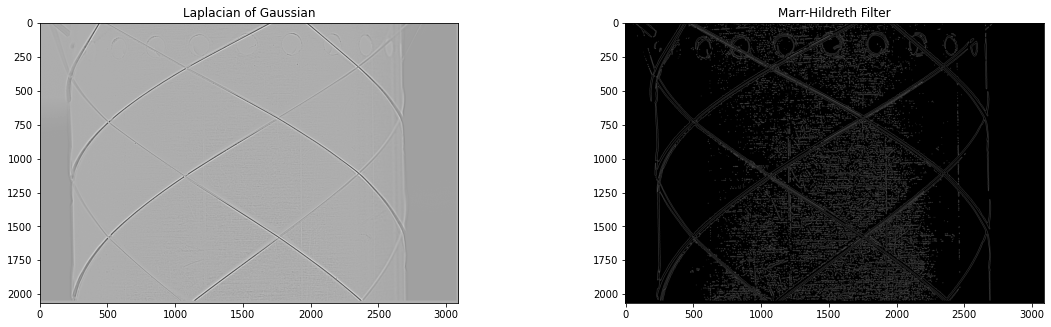

In [14]:
log, zero_crossing = marrFilter(img_gray_origin, sigma=3)

plt.figure(figsize=(18, 10.125))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(121), plt.title('Laplacian of Gaussian'), plt.imshow(log, cmap='gray')
plt.subplot(122), plt.title('Marr-Hildreth Filter'), plt.imshow(zero_crossing, cmap='gray')

TEST: Scharr

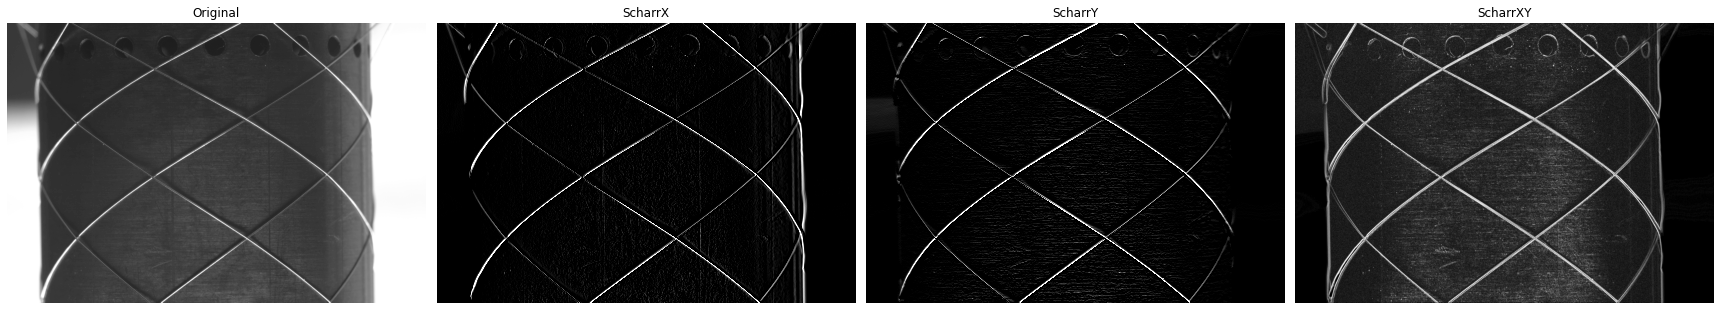

In [15]:
# Scharr kernel
kernScharrX = np.array([[-3, 0, 3], 
                        [-10, 0, 10], 
                        [-3, 0, 3]])  # ScharrX kernel
kernScharrY = np.array([[-3, 10, -3], 
                        [0, 0, 10], 
                        [3, 10, 3]])  # ScharrY kernel

ScharrX = cv2.Scharr(img_gray_origin, cv2.CV_16S, 1, 0)
ScharrY = cv2.Scharr(img_gray_origin, cv2.CV_16S, 0, 1)  
absX = cv2.convertScaleAbs(ScharrX)
absY = cv2.convertScaleAbs(ScharrY)  # format: uint8
ScharrXY = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)  # abs instead of square root

plt.figure(figsize=(24, 13.5))
plt.subplot(141), plt.axis('off'), plt.title("Original"), plt.imshow(img_gray_origin, cmap='gray', vmin=0, vmax=255)
plt.subplot(142), plt.axis('off'), plt.title("ScharrX"), plt.imshow(ScharrX, cmap='gray', vmin=0, vmax=255)
plt.subplot(143), plt.axis('off'), plt.title("ScharrY"), plt.imshow(ScharrY, cmap='gray', vmin=0, vmax=255)
plt.subplot(144), plt.axis('off'), plt.title("ScharrXY"), plt.imshow(ScharrXY, cmap='gray')
plt.tight_layout()
plt.show()

Function: trackbar()

trackerbar() run successful -> CLAHE

In [16]:
# trackbar callback fucntion does nothing
def update_all(x):
    pass

cv2.namedWindow('controls CLAHE', cv2.WINDOW_NORMAL)
#cv2.resizeWindow("controls CLAHE", 300, 300)  

cv2.createTrackbar('clipLimit','controls CLAHE',1,16,update_all)
cv2.createTrackbar('tileGridSize_width','controls CLAHE',1,16,update_all)
cv2.createTrackbar('tileGridSize_height','controls CLAHE',1,16,update_all)

while True:
    clipLimit = float(cv2.getTrackbarPos('clipLimit','controls CLAHE'))
    # tileGridSize_width = int(cv2.getTrackbarPos('tileGridSize_width','controls CLAHE'))
    # tileGridSize_height = int(cv2.getTrackbarPos('tileGridSize_height','controls CLAHE'))
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(8,8))
    clahe_gray = clahe.apply(img_gray_origin)
    
    combined = np.hstack((img_gray_origin, clahe_gray))
    cv2.imshow('controls CLAHE',combined)

    # cv2.waitkey(10)
    # waitfor the user to press `Esc` and break the while loop 
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
	    break
cv2.destroyAllWindows()